# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
import cv2
import csv
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.contrib.layers import flatten
from sklearn.utils import shuffle
from collections import defaultdict, Counter

%matplotlib inline

np.random.seed(42)
tf.set_random_seed(42)
pd.set_option('precision', 3)

In [2]:
import pickle
import platform

if platform.system() == 'Linux':
    data_path = '/home/carnd/CarND-Traffic-Sign-Classifier-Project/datasets/'
else:
    data_path = '/Users/yiwenw/Downloads/datasets/traffic-signs-data/'

training_file = data_path + 'train.p'
validation_file = data_path + 'valid.p'
testing_file = data_path + 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
# the suffix underscore in variable names is used to indicate the original images/labels,
# and they won't be changed
X_train_, y_train_ = train['features'], train['labels']
X_valid_, y_valid = valid['features'], valid['labels']
X_test_, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [3]:
n_train = X_train_.shape[0]
n_validation = X_valid_.shape[0]
n_test = X_test_.shape[0]
image_shape = X_train_[0].shape
n_classes = np.unique(y_train_).size

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

In [4]:
# Read in sign names csv file into a dictionary
sign_names = defaultdict(str)
csvfile = './signnames.csv'

def read_sign_names(fname):
    with open(fname, 'r') as f: 
        reader = csv.reader(f)
        next(reader)
        for row in reader:
            c, name = row
            sign_names[int(c)] = name[:32]
            
read_sign_names(csvfile)

In [5]:
def small_dataset(X, y, classes=None, start_i=0, n_per_class=100):
    """
    Draw a dataset from X and y.
    
    Args:
        X (4D array): the feature data
        y (1D array): the labels
        classes (list like): list of classes to be drawn
        start_i (int): starting index of X and y when drawing samples
        n_per_class (int): the max number of samples drawn from each class
        
    Returns:
        4D array: the drawn feature data
        1D array: the lables for the drawn feature data
        1D array: the indices of the drawn samples
    """
    n_classes = np.unique(y).size if classes is None else len(classes)
    classes_2_fill = set(range(n_classes)) if classes is None else set(classes)        
    filled_per_class = defaultdict(int)   
    small_X, small_y = [], []
    indices = []
    
    for i in range(start_i, len(y)):
        label = y[i]
        if label in classes_2_fill:
            small_X.append(X[i])
            small_y.append(label)
            indices.append(i)
            filled_per_class[label] += 1
            if filled_per_class[label] == n_per_class:
                classes_2_fill.remove(label)
        if not classes_2_fill:
            return np.array(small_X), np.array(small_y), np.array(indices)
    return np.array(small_X), np.array(small_y), np.array(indices)

In [6]:
def plot_images(images, labels, start_i=0, n_images=10):
    n_channels = 1 if images.shape[3] == 1 else 3
    
    plt.figure(figsize=(20, 5))
    for i in range(n_images):
        if (start_i+i) < len(labels):
            plt.subplot(1, n_images, i+1)
            plt.title(labels[start_i+i])
            plt.xticks([])
            plt.yticks([])
            if n_channels == 1:
                img = plt.imshow(images[start_i+i][:,:,0])
            else:
                img = plt.imshow(images[start_i+i])
    plt.show()

def display_images(images, labels, start_i=0, n_images=10):
    input_ = 'c'
    while input_ != 'q' and start_i < len(labels):
        plot_images(images, labels, start_i)
        start_i += n_images
        input_ = input()
        
def display_all_images(images, labels, start_i=0, n_images=10):
    while(start_i < len(labels)):
        plot_images(images, labels, start_i)
        start_i += n_images

#### Display one image per class

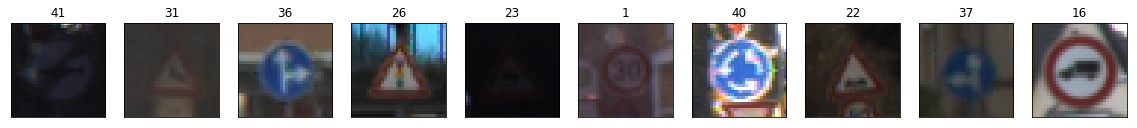

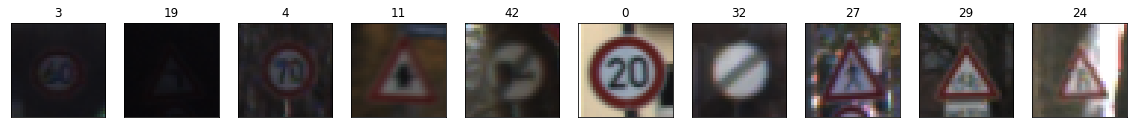

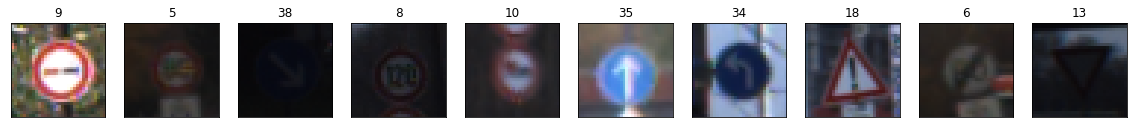

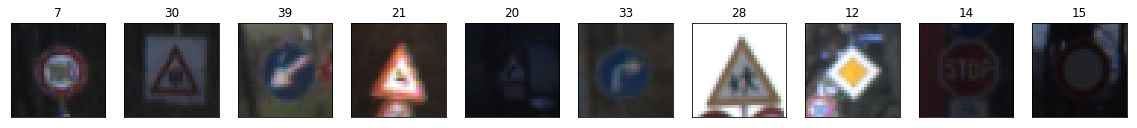

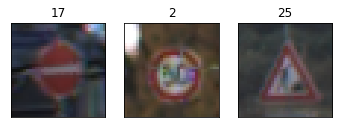

In [7]:
# Display one image per class

x_demo, y_demo, _ = small_dataset(X_train_, y_train_, classes=None, start_i=200, n_per_class=1)
display_all_images(x_demo, y_demo)

#### Plot histograms of class distributions

Class distributions:


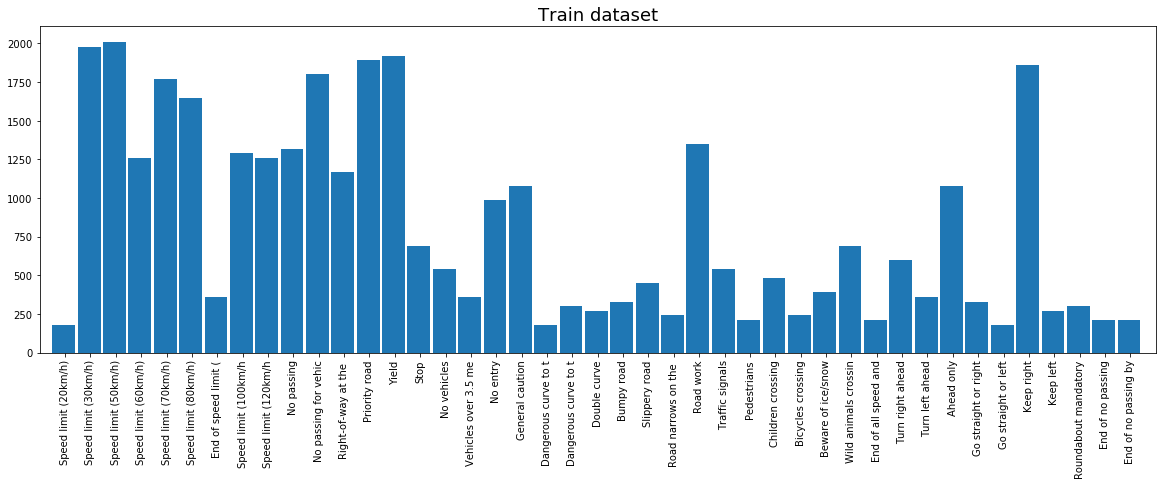

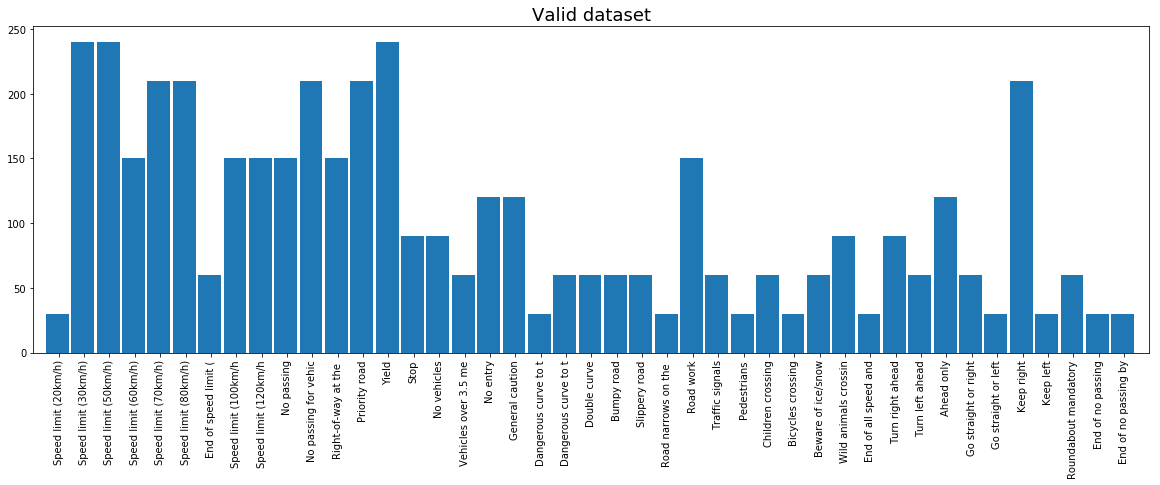

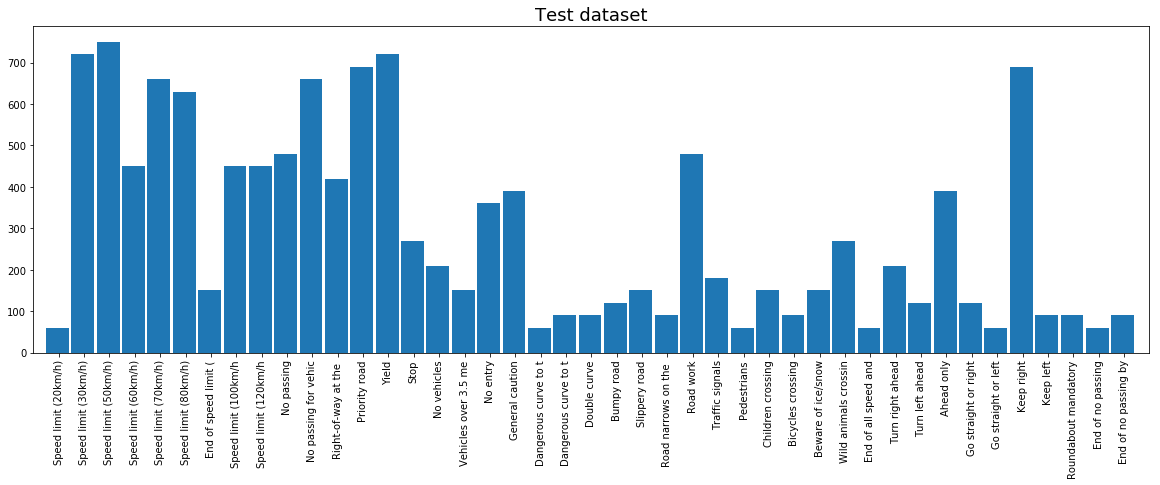

In [8]:
# plot histograms for train, validation, and test

names = [s[:20] for s in list(sign_names.values())]
bins = np.arange(n_classes + 1) - 0.5

print("Class distributions:")
plt.figure(1, figsize=(20, 6))
plt.title("Train dataset", fontsize=18)
plt.hist(y_train_, bins=bins, width=0.9)
plt.xticks(range(n_classes), names, rotation=90)
plt.xlim(-1, n_classes)

plt.figure(2, figsize=(20, 6))
plt.title("Valid dataset", fontsize=18)
plt.hist(y_valid, bins=bins, width=0.9)
plt.xticks(range(n_classes), names, rotation=90)
plt.xlim(-1, n_classes)

plt.figure(3, figsize=(20, 6))
plt.title("Test dataset", fontsize=18)
plt.hist(y_test, bins=bins, width=0.9)
plt.xticks(range(n_classes), names, rotation=90)
plt.xlim(-1, n_classes)

plt.show()

Apparently the class distribution is imbalanced for all training, validation, and test datasets; however, the three distributions share a similar pattern. We can also see that the distributions of training and test datasets are almost identical.  
  
##### Is augmenting data to make the class distribution more balanced necessary?  
  
It will be helpful to make the distribution less imbalanced. We will come back to this after we train the model and examine the predicting results on test set.

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [9]:
### Preprocess the data here. It is required to normalize the data. Other preprocessing steps could include 
### converting to grayscale, etc.

In [10]:
def rgb_2_gray(X):
    """
    Convert images from RGB to grayscale.
    """
    grays = []
    for image in X:
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        grays.append(image)
    return np.expand_dims(np.array(grays), axis=3)

In [11]:
# Do data augmentation before images being prepocessed (preprocessing is like normalized, grayscaled).
# Using ImageDataGenerator, which generates images in training step, we need to keep two
# different copies of images: one to keep original images, and the other (normalized) for 
# training, evaluating loss and accuracy, etc.

X_train = X_train_.copy()
y_train = y_train_.copy()
X_train_norm = (X_train_ - 128.) / 128.
y_train_norm = y_train_.copy()
X_valid = (X_valid_ - 128.) / 128.
X_test = (X_test_ - 128.) / 128.

print(X_train.shape, X_train_norm.shape, X_valid.shape, X_test.shape)

(34799, 32, 32, 3) (34799, 32, 32, 3) (4410, 32, 32, 3) (12630, 32, 32, 3)


In [12]:
# Set up the image augmentation generator

from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
                            rotation_range=10,
                            width_shift_range=0.1,
                            height_shift_range=0.05,
#                             rescale=1./255,
#                             shear_range=0.2,
                            zoom_range=0.1,
                            horizontal_flip=False,
                            fill_mode='nearest')

Using TensorFlow backend.


### Model Architecture

In [13]:
# Use the LeNet-5 with dropout for fully-connected layers

import tensorflow as tf
from tensorflow.contrib.layers import flatten

def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1

    # Convnet 1: Input = 32x32x1. Output = 28x28x6.
    with tf.variable_scope('conv1') as scope:
        kernel = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), mean=mu, stddev=sigma),
                             name='weights')
        biases = tf.Variable(tf.zeros(6), name='biases')
        pre_activation = tf.nn.conv2d(x, kernel, strides=[1, 1, 1, 1], padding='VALID') + biases
        conv1 = tf.nn.relu(pre_activation, name=scope.name)

    # Pooling 1: Input = 28x28x6. Output = 14x14x6.
    pool1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID',
                           name='pool1')

    # Convnet 2: Input = 14x14x6. Output = 10x10x16.
    with tf.variable_scope('conv2') as scope:
        kernel = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean=mu, stddev=sigma),
                              name='weights')
        biases = tf.Variable(tf.zeros(16), name='biases')
        pre_activation = tf.nn.conv2d(pool1, kernel, strides=[1, 1, 1, 1], padding='VALID') + biases
        conv2 = tf.nn.relu(pre_activation, name=scope.name)

    # Pooling 2: Input = 10x10x16. Output = 5x5x16.
    pool2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID',
                           name='pool2')

    # Flatten: Input = 5x5x16. Output = 400.
    fc0 = flatten(pool2)
    
    # FC 3: Input = 400. Output = 120.
    with tf.variable_scope('fc1') as scope:
        weights = tf.Variable(tf.truncated_normal(shape=(400, 120), mean=mu, stddev=sigma),
                              name='weights')
        biases = tf.Variable(tf.zeros(120), name='biases')
        pre_activation = tf.matmul(fc0, weights) + biases
        fc1 = tf.nn.relu(pre_activation, name=scope.name)
        
    dropout1 = tf.nn.dropout(fc1, keep_prob=keep_prob, name='dropout1')

    # FC 4: Input = 120. Output = 84.
    with tf.variable_scope('fc2') as scope:
        weights = tf.Variable(tf.truncated_normal(shape=(120, 84), mean=mu, stddev=sigma),
                               name='weights')
        biases = tf.Variable(tf.zeros(84), name='biases')
        pre_activation = tf.matmul(dropout1, weights) + biases
        fc2 = tf.nn.relu(pre_activation, name=scope.name)
        
    dropout2 = tf.nn.dropout(fc2, keep_prob=keep_prob, name='dropout2')

    # Output 5: Input = 84. Output = 43.
    with tf.variable_scope('output') as scope:
        weights = tf.Variable(tf.truncated_normal(shape=(84, 43), mean=mu, stddev=sigma),
                              name='weights')
        biases = tf.Variable(tf.zeros(43), name='biases')
        logits = tf.matmul(dropout2, weights) + biases
    
    return logits

In [14]:
x = tf.placeholder(tf.float32, (None, *image_shape), name='x')
y = tf.placeholder(tf.int32, (None), name='y')
keep_prob = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y, n_classes)

In [15]:
learning_rate = 0.001

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_operation = optimizer.minimize(loss_operation)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [16]:
def plot_eval(losses, metrics):
    plt.figure(figsize=(20, 8))
    plt.subplot(121)
    plt.plot(losses[0], label='train')
    plt.plot(losses[1], label='valid')
    plt.title('Loss')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.legend(loc='best')
    plt.subplot(122)
    plt.title('Accuracy')
    plt.plot(metrics[0], label='train')
    plt.plot(metrics[1], label='valid')
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.legend(loc='best')
    plt.show()

In [17]:
EPOCHS = 201
BATCH_SIZE = 128

#### Train and validate the model

Training...

EPOCH 1 ... Train Loss = 1.29577 - Valid Loss = 1.47002 - Train Accuracy = 0.624 - Valid Accuracy = 0.556
EPOCH 6 ... Train Loss = 0.16177 - Valid Loss = 0.29555 - Train Accuracy = 0.965 - Valid Accuracy = 0.918
EPOCH 11 ... Train Loss = 0.07017 - Valid Loss = 0.18967 - Train Accuracy = 0.985 - Valid Accuracy = 0.945
EPOCH 16 ... Train Loss = 0.04604 - Valid Loss = 0.19760 - Train Accuracy = 0.989 - Valid Accuracy = 0.946
EPOCH 21 ... Train Loss = 0.03106 - Valid Loss = 0.14437 - Train Accuracy = 0.993 - Valid Accuracy = 0.954
EPOCH 26 ... Train Loss = 0.02482 - Valid Loss = 0.12709 - Train Accuracy = 0.995 - Valid Accuracy = 0.966
EPOCH 31 ... Train Loss = 0.01620 - Valid Loss = 0.13847 - Train Accuracy = 0.997 - Valid Accuracy = 0.960
EPOCH 36 ... Train Loss = 0.01575 - Valid Loss = 0.11629 - Train Accuracy = 0.997 - Valid Accuracy = 0.964
EPOCH 41 ... Train Loss = 0.01216 - Valid Loss = 0.12112 - Train Accuracy = 0.997 - Valid Accuracy = 0.966
EPOCH 46 ... Train Loss = 

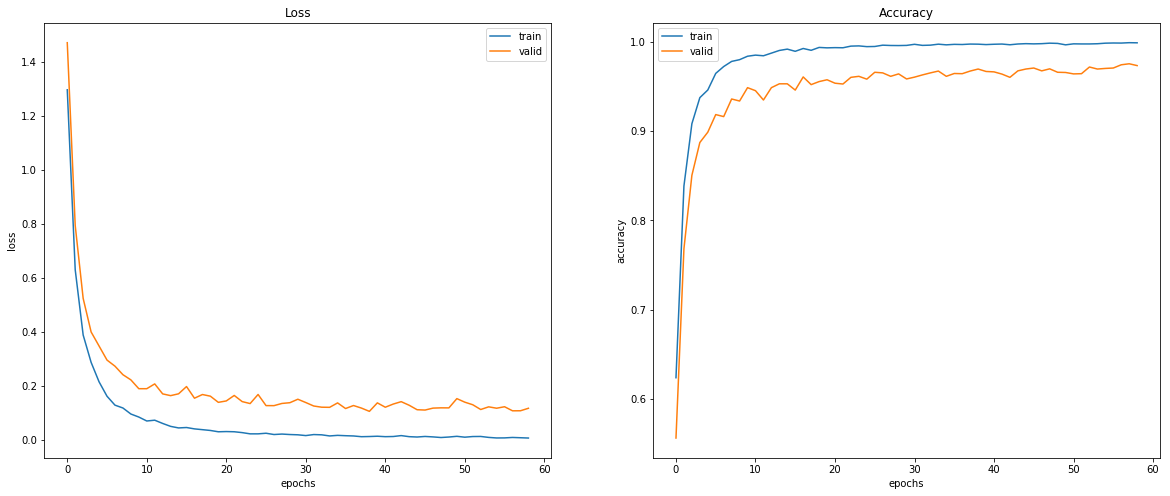

In [18]:
# %%script false
train_accus, valid_accus = [], []
train_loss, valid_loss = [], []
min_loss_v = 9999.
PATIENCE = 20

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        batch_gen = datagen.flow(X_train, y=y_train, batch_size=32)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            gen_batch_x, gen_batch_y = batch_gen.next()
            gen_batch_x = gen_batch_x.astype(np.uint8)
            batch_x = np.concatenate([batch_x, gen_batch_x])
            batch_y = np.concatenate([batch_y, gen_batch_y])
            batch_x = (batch_x - 128.) / 128.
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})

        loss_t = sess.run(loss_operation, feed_dict={x: X_train_norm, y: y_train_norm, keep_prob: 1.})  
        train_loss.append(loss_t)
        loss_v = sess.run(loss_operation, feed_dict={x: X_valid, y: y_valid, keep_prob: 1.}) 
        valid_loss.append(loss_v)
        train_accuracy = evaluate(X_train_norm, y_train_norm)
        train_accus.append(train_accuracy)
        valid_accuracy = evaluate(X_valid, y_valid)
        valid_accus.append(valid_accuracy)
        if i % 5 == 0:
            print("EPOCH {} ...".format(i+1), end=' ')
            print("Train Loss = {:.5f}".format(loss_t), end=' - ')
            print("Valid Loss = {:.5f}".format(loss_v), end=' - ')
            print("Train Accuracy = {:.3f}".format(train_accuracy), end=' - ')
            print("Valid Accuracy = {:.3f}".format(valid_accuracy))
            
        # Early stopping
        if loss_v < min_loss_v:
            min_loss_v = loss_v
            patience = PATIENCE
        else:
            patience -= 1
            if patience == 0:
                break
        
    saver.save(sess, './t_signs_5_color')
    print("Model saved")
    plot_eval((train_loss, valid_loss), (train_accus, valid_accus))

#### Run model on test data

In [19]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

    logits_ = sess.run(logits, feed_dict={x: X_test, keep_prob: 1.})
    y_test_pred = np.argmax(logits_, axis=-1)
    correct_pred = y_test_pred == y_test
    incorrect_pred = np.logical_not(correct_pred)
    print("Number of incorrectly classified test images = {}".format(np.sum(incorrect_pred)))

Test Accuracy = 0.960
Number of incorrectly classified test images = 508


#### Analysis of model performance on test set
How well the model perform per class?

In [20]:
X_test_incorr = X_test_[incorrect_pred]  # incorrectly classified images
y_test_incorr = y_test[incorrect_pred]   # target labels for incorrectly classified images
y_test_pred_incorr = y_test_pred[incorrect_pred]  # predicted labels for incorrectly classified images
X_test_corr = X_test_[correct_pred]
y_test_pred_corr = y_test_pred[correct_pred]

In [21]:
# precision = tp / (tp + fp)
# recall = tp / (tp + fn)

test_stats = defaultdict(dict)
classes = sorted(np.unique(y_train))
counts = Counter(y_test)

for c in classes:
    c_indices = np.where(y_test==c)[0]
    c_pred_indices = np.where(y_test_pred==c)[0]
    test_stats[c]['count'] = counts.get(c, 0)
    test_stats[c]['sign_type'] = sign_names[c]
    test_stats[c]['true_pos_ids'] = np.where(np.logical_and(y_test_pred==c, y_test==c))[0]
    test_stats[c]['false_pos_ids'] = np.where(np.logical_and(y_test_pred==c, y_test!=c))[0]
    test_stats[c]['false_neg_ids'] = np.where(np.logical_and(y_test==c, y_test_pred!=c))[0]    
    test_stats[c]['true_pos'] = np.sum(np.logical_and(y_test_pred==c, y_test==c))
    test_stats[c]['false_pos'] = np.sum(np.logical_and(y_test_pred==c, y_test!=c))
    test_stats[c]['false_neg'] = np.sum(np.logical_and(y_test==c, y_test_pred!=c))
    

In [22]:
df = pd.DataFrame.from_dict(test_stats, orient='index')
df = df[['sign_type', 'count', 'true_pos', 'false_pos', 'false_neg']]
df['error_rate'] = df['false_neg'] / df['count']
df['precision'] = df['true_pos'] / (df['true_pos'] + df['false_pos'])
df['recall'] = df['true_pos'] / (df['true_pos'] + df['false_neg'])

In [23]:
# Print per class statistics

print("Model statistics on test set:")
df

Model statistics on test set:


,sign_type,count,true_pos,false_pos,false_neg,error_rate,precision,recall
0,Speed limit (20km/h),60,44,0,16,0.267,1.000,0.733
1,Speed limit (30km/h),720,707,17,13,0.018,0.977,0.982
2,Speed limit (50km/h),750,735,21,15,0.020,0.972,0.980
3,Speed limit (60km/h),450,436,28,14,0.031,0.940,0.969
4,Speed limit (70km/h),660,644,12,16,0.024,0.982,0.976
5,Speed limit (80km/h),630,590,24,40,0.063,0.961,0.937
6,End of speed limit (80km/h),150,128,4,22,0.147,0.970,0.853
7,Speed limit (100km/h),450,396,10,54,0.120,0.975,0.880
8,Speed limit (120km/h),450,444,57,6,0.013,0.886,0.987
9,No passing,480,478,14,2,0.004,0.972,0.996


#### Let's check those classes with recall < 80%

In [24]:
# Pick at most 20 samples of correct and incorrect images from each class

def plot_correct_incorrect_images(classes, n_per_class=20):
    """
    Plot correctly and incorrectly classified images for each given class in 
    the given argument 'classes'.
    
    Args:
        classes (list like): list of classes to be plotted
        n_per_class (int): number of images to be plotted per category (correct
        vs. incorrect) per class
    Returns:
        None
    """
    img_lrc_corr, label_lrc_corr, _ = small_dataset(X_test_corr, 
                                                    y_test_pred_corr,
                                                    classes=classes,
                                                    n_per_class=n_per_class)
    img_lrc_err, label_lrc_err, indices = small_dataset(X_test_incorr,
                                                        y_test_incorr,
                                                        classes=classes,
                                                        n_per_class=n_per_class)
    label_corr_pred = np.array([str(y_test_incorr[i])+' / '+str(y_test_pred_incorr[i]) \
                                for i in indices])

    for c in classes:
        mask = label_lrc_corr == c
        print("Correctly classified class_{}".format(c))
        display_all_images(img_lrc_corr[mask], label_lrc_corr[mask])
        mask = label_lrc_err == c
        print("Incorrectly classified class_{} (target / prediction)".format(c))
        display_all_images(img_lrc_err[mask], label_corr_pred[mask])

In [25]:
df_lrc = df[df.recall < 0.8]
df_lrc

,sign_type,count,true_pos,false_pos,false_neg,error_rate,precision,recall
0,Speed limit (20km/h),60,44,0,16,0.267,1.000,0.733
21,Double curve,90,55,23,35,0.389,0.705,0.611
27,Pedestrians,60,29,22,31,0.517,0.569,0.483
30,Beware of ice/snow,150,115,11,35,0.233,0.913,0.767


#### Visualize class images of recall < 80%

Correctly classified class_0


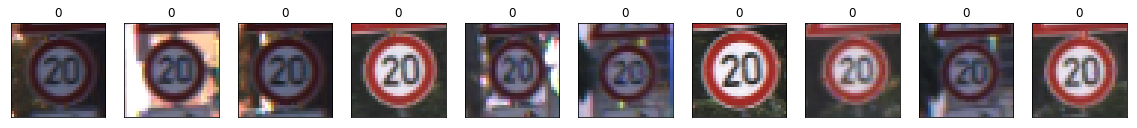

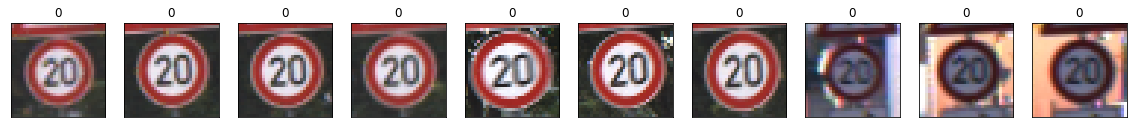

Incorrectly classified class_0 (target / prediction)


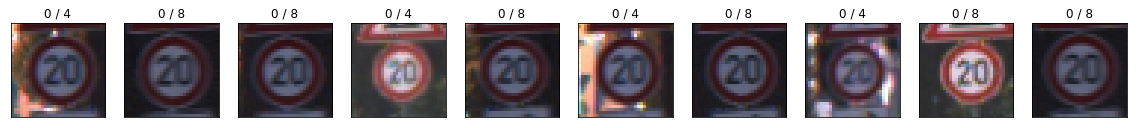

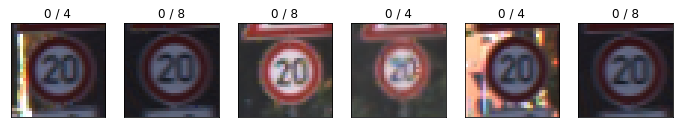

Correctly classified class_21


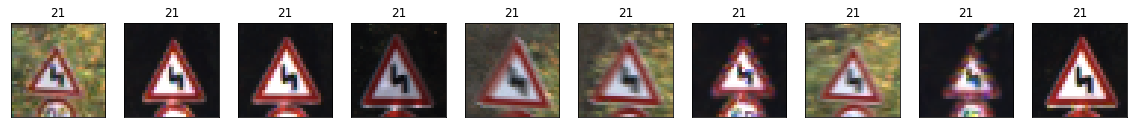

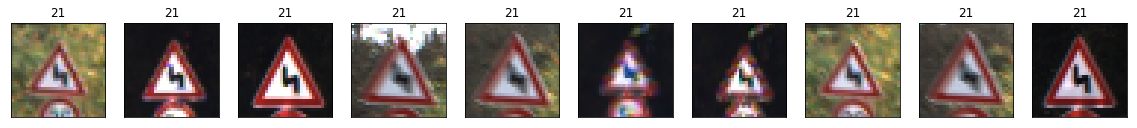

Incorrectly classified class_21 (target / prediction)


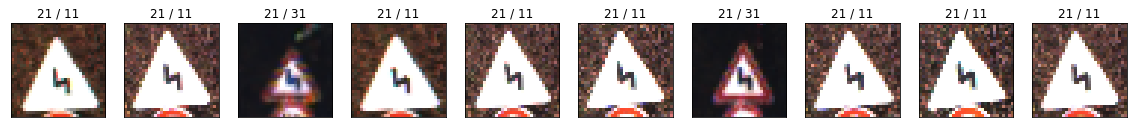

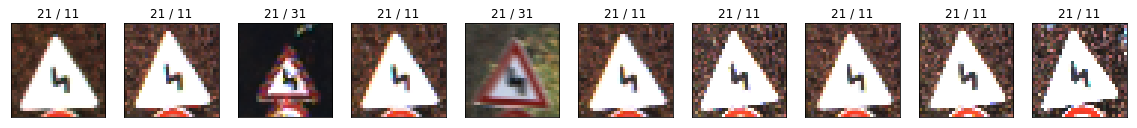

Correctly classified class_27


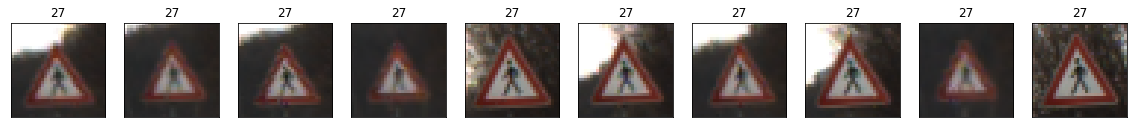

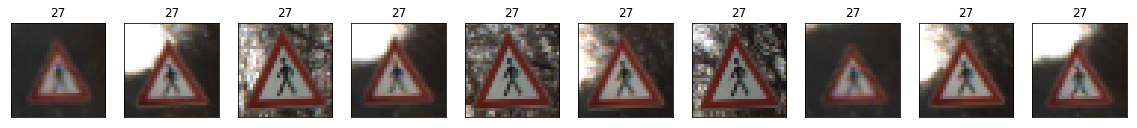

Incorrectly classified class_27 (target / prediction)


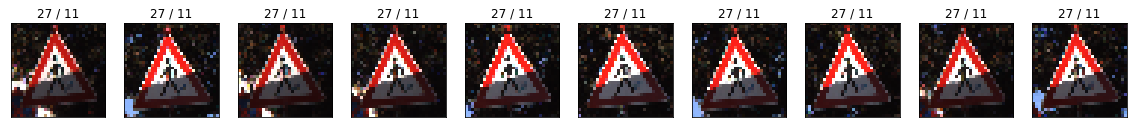

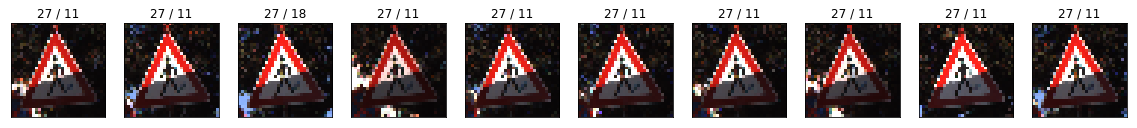

Correctly classified class_30


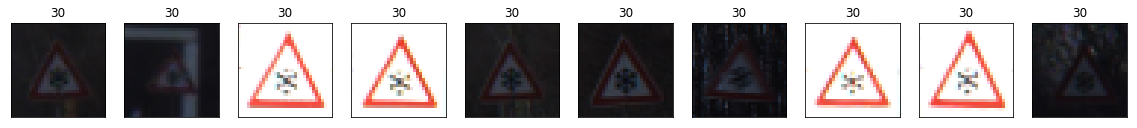

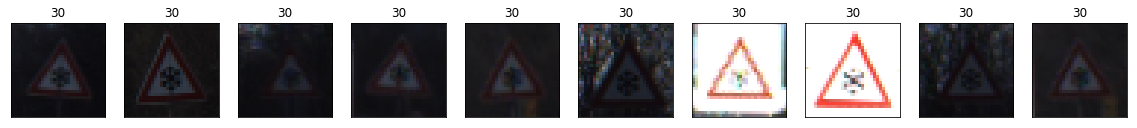

Incorrectly classified class_30 (target / prediction)


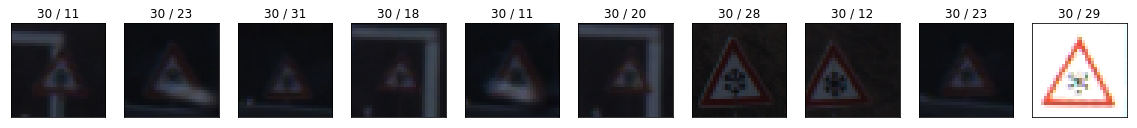

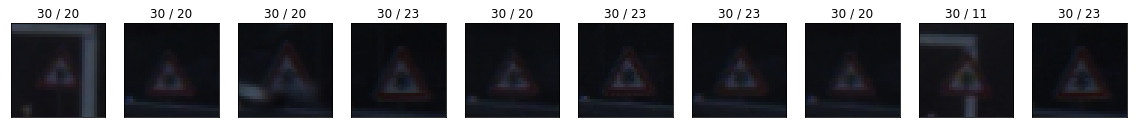

In [26]:
plot_correct_incorrect_images(df_lrc.index)

Except for class_19 'Dangerous curve to the left', we can see that most of these mis-classified images are being artificial and unlikely to be seen in a real roadside.  
  
class_21 'Double curve': completely different color tone (strong brightness)  
class_27 'Pedestrians': totally different resolution and lighting  
class_30 'Beware of ice/snow': for those mis-classified real signs, except one that is much shifted to the left, most are heavily blurred that even human eyes cannot tell  
  
Possible technique to improve the recall for class_19: Augmenting more darkened images.

#### And those classes with 80% < recall < 90% 

In [27]:
df_lrc_2 = df[(0.8 <= df.recall) & (df.recall < 0.9)]
df_lrc_2

,sign_type,count,true_pos,false_pos,false_neg,error_rate,precision,recall
6,End of speed limit (80km/h),150,128,4,22,0.147,0.970,0.853
7,Speed limit (100km/h),450,396,10,54,0.120,0.975,0.880
18,General caution,390,337,27,53,0.136,0.926,0.864
19,Dangerous curve to the left,60,49,3,11,0.183,0.942,0.817
24,Road narrows on the right,90,73,6,17,0.189,0.924,0.811


Correctly classified class_6


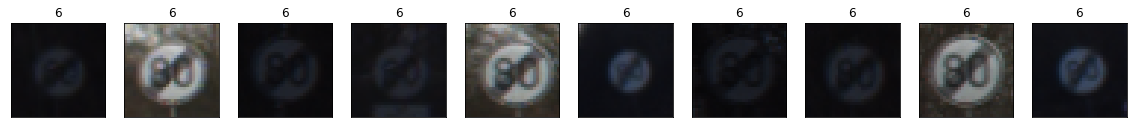

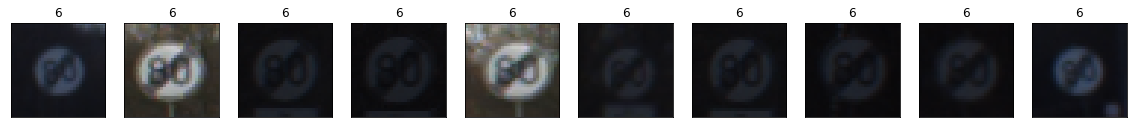

Incorrectly classified class_6 (target / prediction)


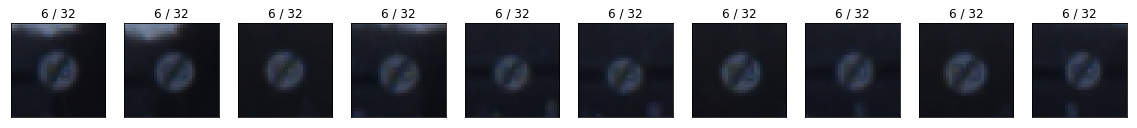

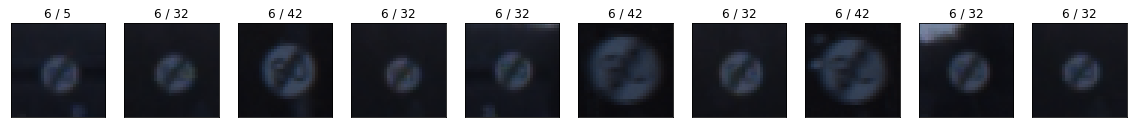

Correctly classified class_7


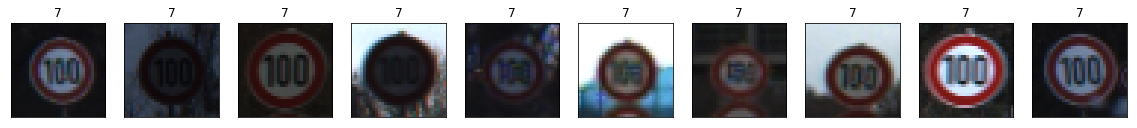

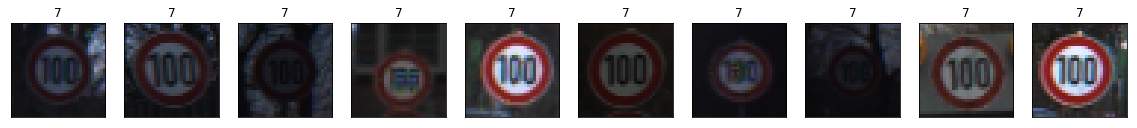

Incorrectly classified class_7 (target / prediction)


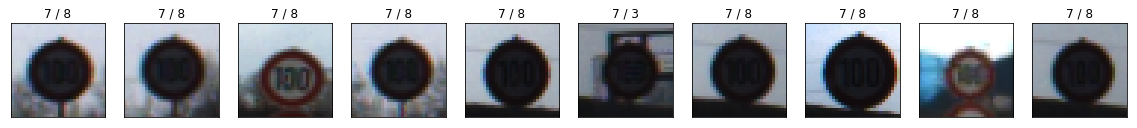

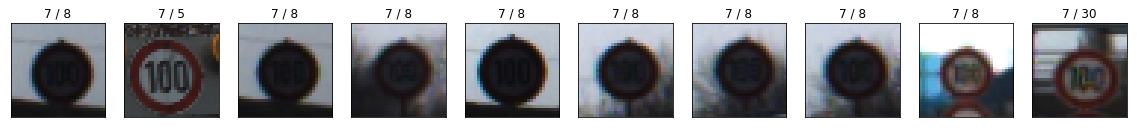

Correctly classified class_18


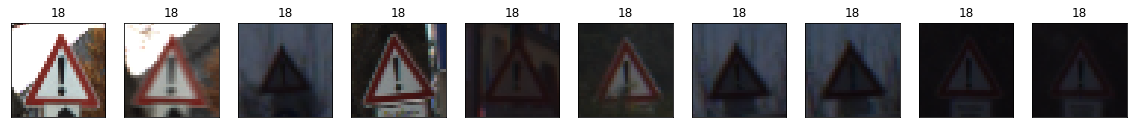

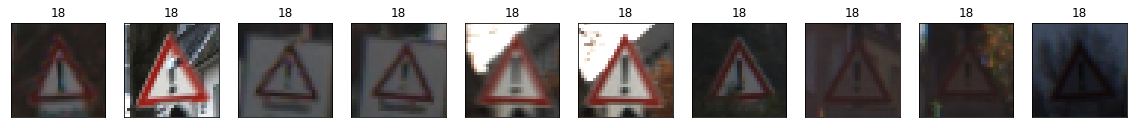

Incorrectly classified class_18 (target / prediction)


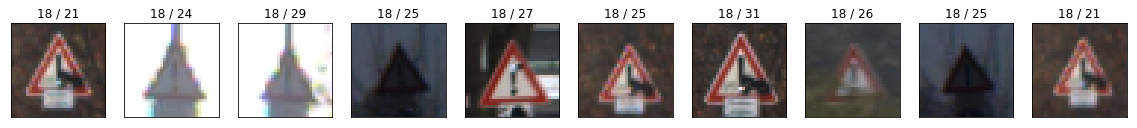

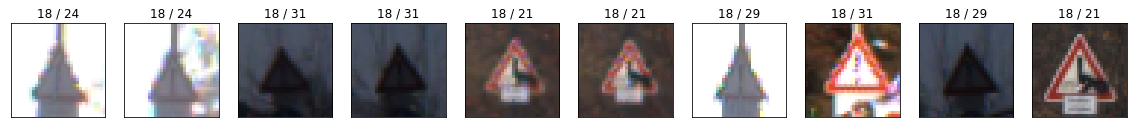

Correctly classified class_19


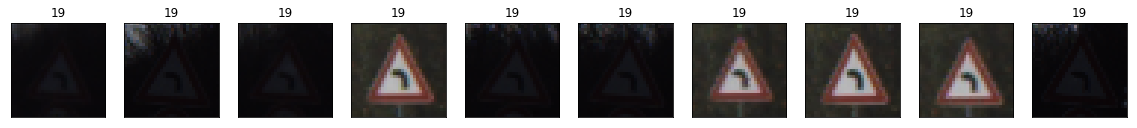

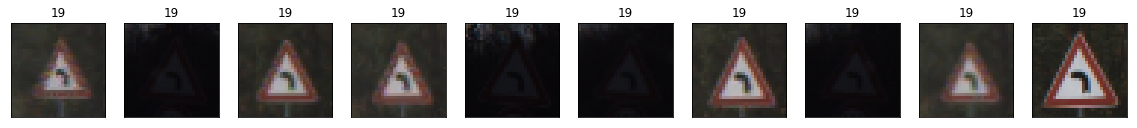

Incorrectly classified class_19 (target / prediction)


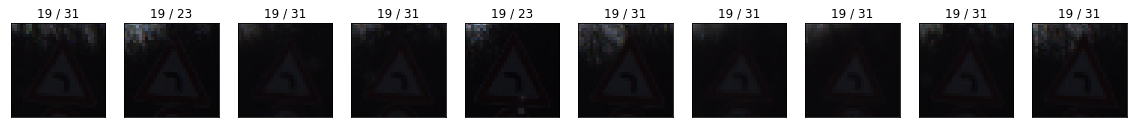

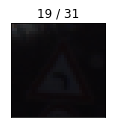

Correctly classified class_24


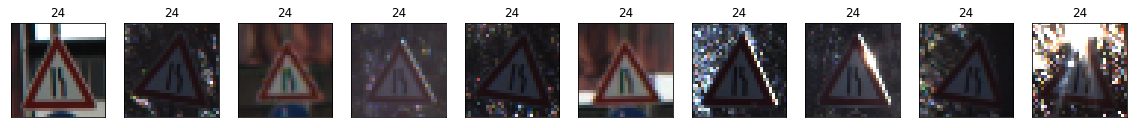

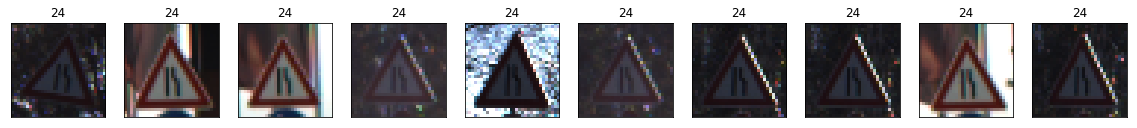

Incorrectly classified class_24 (target / prediction)


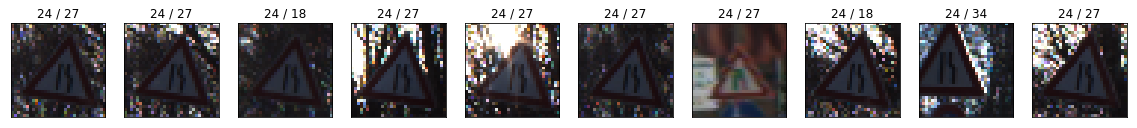

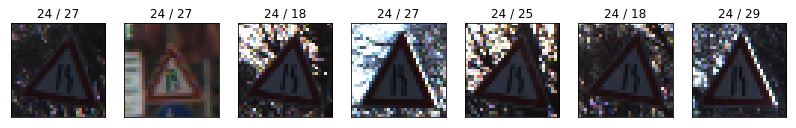

In [28]:
plot_correct_incorrect_images(df_lrc_2.index)

This group of images is more reasonable than the previous one.
  
We can see that the performance of class_0 'Speed limit (20km/h)' and class_24 'Road narrows on the right' can possibily be improved by augmenting the original data via some simple transformations (i.e. small shifting and/or zooming), since they also have the least training samples.
  
For other classes, most of those mis-classified test images are quite different from the ones that are correctly classified (and thus could also be very different from the training set).  
For example:   
  
class_6 'End of speed limit (80km/h)': much smaller  
class_7 'Speed limit (100km/h)': much darker or lightly stained  
class_18 'General caution': severely stained or in different color scheme  

To improve the performance on above three classes, we can augment data focusing on the difficult characteristics (i.e. small size, lighting, big noise). However, the augmentation should be applied to all classes, and we should not try to create a training set that purposely matches special characteristics of the test set.

#### Let's also take a quick look at the classes with precision < 80%

In [29]:
df_lp = df[df.precision < 0.8]
df_lp

,sign_type,count,true_pos,false_pos,false_neg,error_rate,precision,recall
21,Double curve,90,55,23,35,0.389,0.705,0.611
27,Pedestrians,60,29,22,31,0.517,0.569,0.483
32,End of all speed and passing lim,60,60,19,0,0.000,0.759,1.000


Images that are mis-classified to class_21 'Double curve'


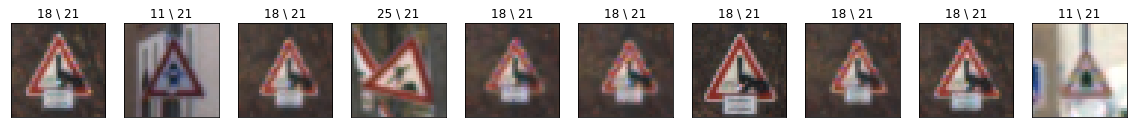

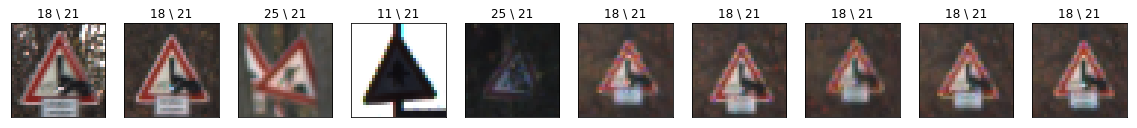

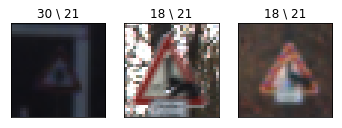

Images that are mis-classified to class_27 'Pedestrians'


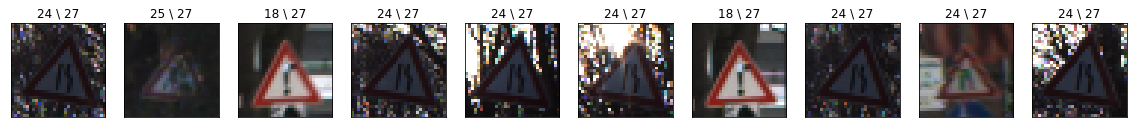

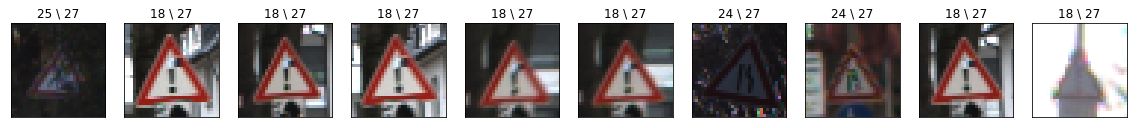

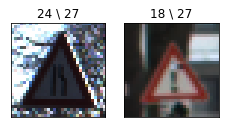

Images that are mis-classified to class_32 'End of all speed and passing lim'


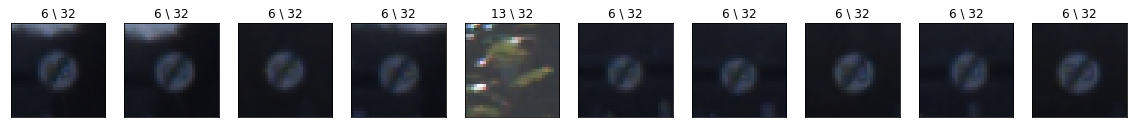

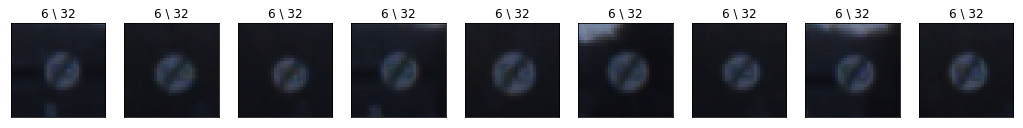

In [30]:
for c in df_lp.index:
    fp_ids = test_stats[c]['false_pos_ids']
    images = X_test_[fp_ids]
    labels = y_test[fp_ids]
    labels_pred = y_test_pred[fp_ids]
    labels_both = [str(l1)+' \ '+str(l2) for (l1, l2) in zip(labels, labels_pred)]
    print("Images that are mis-classified to class_{} '{}'".format(c, sign_names[c]))
    display_all_images(images, labels_both)

The false positive images for class_21 'Double curve' and class_23 'Slippery Road' are challenging and hardly being classified to a class.  
  
On the other hand, the false positive images for class_27 'Pedestrians' and class_32 'End of all speed and passing lim' are more managable. But why those images would be mis-classified to 'Pedestrians' and 'End of all speed and passing lim'? Notice that these two classes have the least training samples. It's likely that the model has not learned enough features from the class samples so that the features it learned have much overlap with the features of other classes.  
  
To improve precision: get more data for these classes via augmentation.

#### From above analysis, we can see that augmenting the training set can possibily improve the performance, especially for the classes with least training samples.

---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images
I decided to use new images more than 5. Since there are 43 classes in total, picking 5 images to test the model can easliy mis-represnt the model's accuracy etc. Of course, ~30 images are still not enough, the more the better.  
  
The images are selected to have at least one of the following characteristics :
- normal and clear
- shifted
- blurred / low resolution
- deformed

In [31]:
### Load the images and plot them here.

In [32]:
import matplotlib.image as mpimg
import os

def read_images_from_dir(image_dir, has_label=False):
    """
    Read JPG images from the given directory, return images of size 32x32.
    Images labels are also extracted from the file name and returned,
    if the argument has_label is True.
    """
    
    valid_exts = ('jpeg', 'jpg', 'JPEG', 'JPG')
    files = sorted([f for f in os.listdir(image_dir) if f.split('.')[-1] in valid_exts])
    images, labels = [], []

    for f in files:
        img_name, f_ext = f.split('.')
        if f_ext in valid_exts:
            img = mpimg.imread(os.path.join(image_dir, f))
            if img.shape != (32, 32):
                img = cv2.resize(img, (32, 32))
            images.append(img)
            if has_label:
                try:
                    label = int(img_name.split('_')[-1])
                    labels.append(label)
                except:
                    raise ValueError( 
                          "File name {} is not properly suffixed with label.".format(f))
                    
    images, labels = np.array(images), np.array(labels)
    
    if has_label:
        return images, labels, files
    return images, files

In [33]:
if platform.system() == 'Linux':
    image_dir = '/home/carnd/CarND-Traffic-Sign-Classifier-Project/new_images/'
else:
    image_dir = '/Users/yiwenw/Documents/Udacity/SDCND/term1/CarND-Traffic-Sign-Classifier-Project/new_images/'

# Use underline suffix to indicate it's the original images
images_, labels, files = read_images_from_dir(image_dir, has_label=True)
images = (images_ - 128.) / 128.
print("Number of new image examples: {}".format(images.shape[0]))
print("New Image data shape: {}".format(images[0].shape))      

Number of new image examples: 25
New Image data shape: (32, 32, 3)


### Predict the Sign Type for Each Image

In [34]:
### Predict the Sign Type for Each Image

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    output = sess.run(logits, feed_dict={x: images, keep_prob: 1.})
    predicts = np.argmax(output, axis=1)
    print("{:25} {:3} {:6} {}".format('Image', 'Target', 'Top1', 'Top1_Sign_name'))
    print('-' * 60)
    for f, label, pred in zip(files, labels, predicts):
        print("{:25} {:>3} {:>6}   {}". format(f.split('.')[0], label, pred, sign_names[pred]))

Image                     Target Top1   Top1_Sign_name
------------------------------------------------------------
end_of_speed_limit_6        6      6   End of speed limit (80km/h)
general_caution_18         18     18   General caution
keep_left_39               39     39   Keep left
keep_right2_38             38     38   Keep right
no_entry_17                17     17   No entry
no_passing2_9               9      9   No passing
no_passing_9                9      9   No passing
pedestrians_27             27     27   Pedestrians
priority_road2_12          12     12   Priority road
priority_road_12           12     12   Priority road
r_of_way_next_int_11       11     11   Right-of-way at the next interse
road_work2_25              25     11   Right-of-way at the next interse
road_work3_25              25     25   Road work
road_work4_25              25     25   Road work
round_mandatory_40         40     40   Roundabout mandatory
speed_limit120_8            8      2   Speed limit (50km

### Analyze Performance

In [35]:
### Calculate the accuracy for the new images. 

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    images_accuracy = evaluate(images, labels)
    print("New Images Accuracy = {:.3f}".format(images_accuracy))

New Images Accuracy = 0.800


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tf.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [36]:
def plot_prediction(image, image_name, pred_probs, pred_labels, correct_i=None, k=5):
    plt.figure(figsize=(15, 2))
    plt.subplot(121)
    plt.title(image_name)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(image)
    plt.subplot(122)
    bars = plt.barh(range(k), pred_probs[::-1], alpha=0.5)
    if correct_i is not None:
        bars[k-1-correct_i].set_color('g')
    for i, p in enumerate(pred_probs[::-1]):
        plt.text(p + 0.02, i - 0.25, str(p), color='blue')
    plt.yticks(range(k), pred_labels[::-1])
    plt.xticks([])
#     plt.tight_layout()
    plt.show()

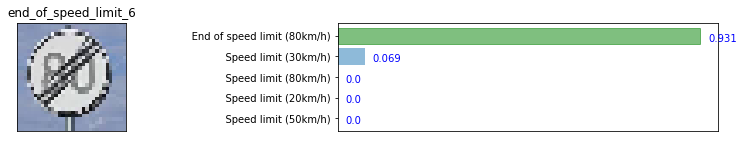

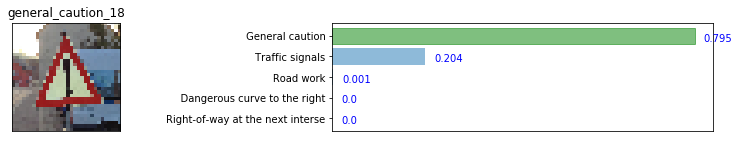

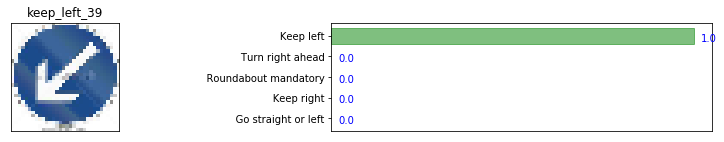

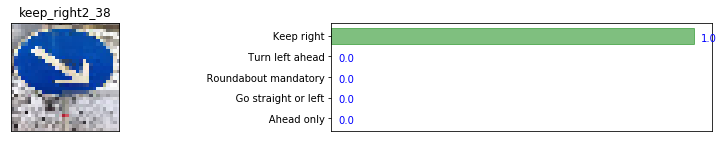

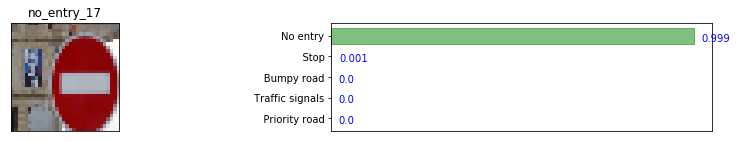

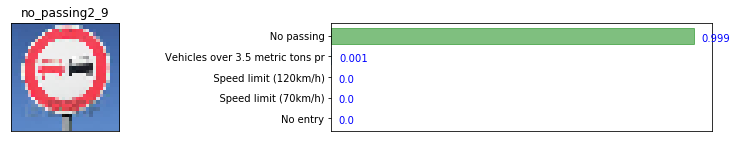

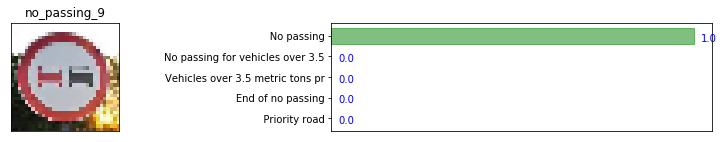

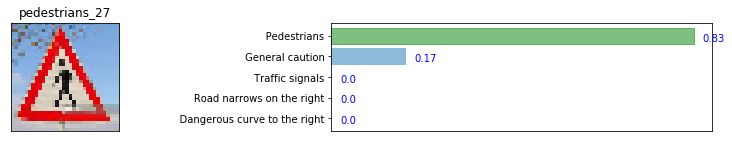

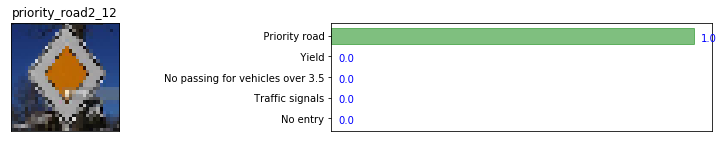

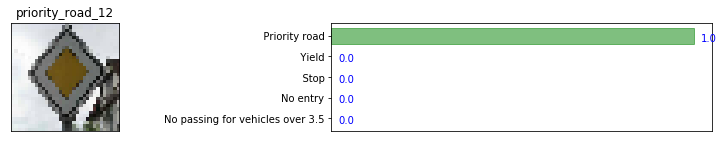

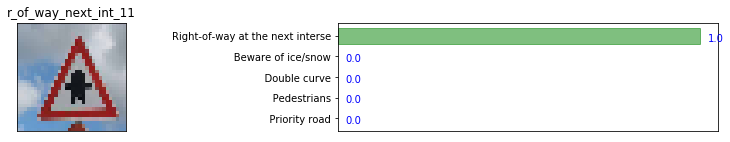

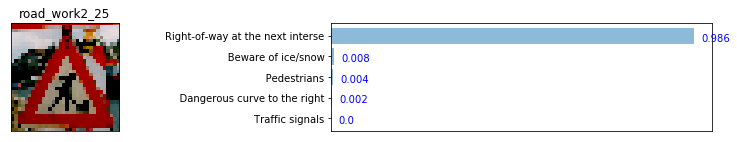

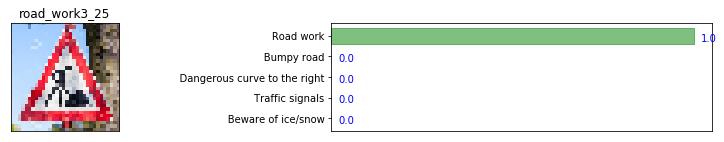

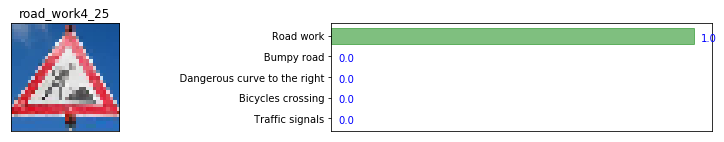

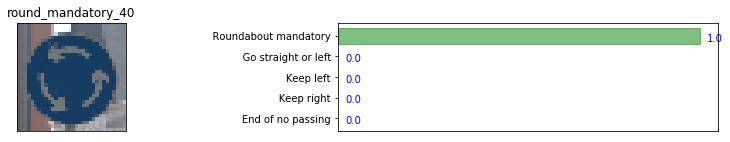

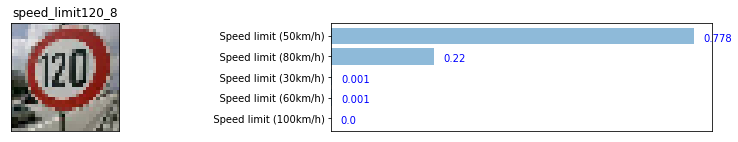

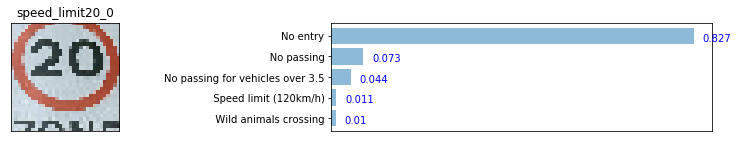

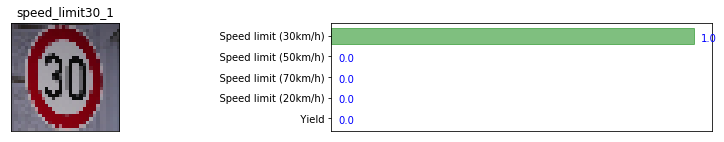

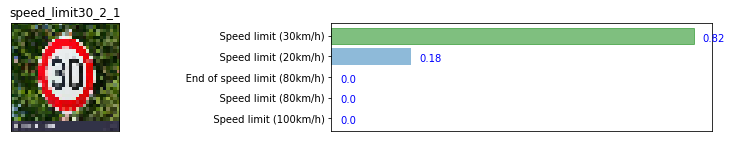

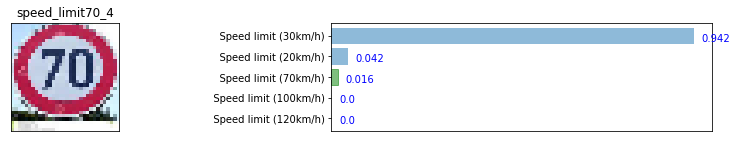

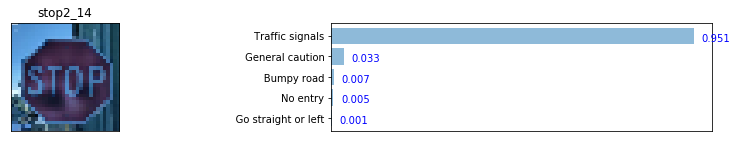

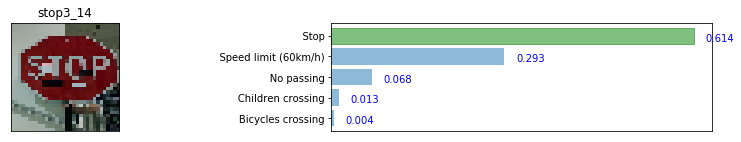

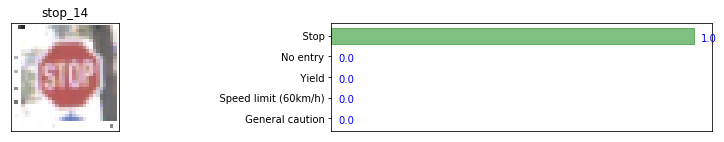

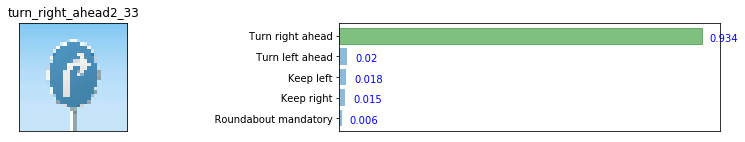

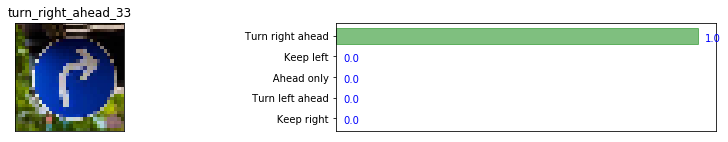

In [37]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 

k = 5
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    softmax = sess.run(tf.nn.softmax(logits), feed_dict={x: images, keep_prob: 1.})
    probs, pred_labels = sess.run(tf.nn.top_k(tf.constant(softmax), k=k))
    
    for image, f, prob, pred_labels, label in zip(images, files, probs, pred_labels, labels):
        image = mpimg.imread(os.path.join(image_dir, f))
        image = cv2.resize(image, (32, 32))
        correct_i = list(pred_labels).index(label) if label in pred_labels else None
        prob = np.around(prob, 3)
        pred_names = ['{:>40}'.format(sign_names[i]) for i in pred_labels]
        plot_prediction(image, f.split('.')[0], prob, pred_names, correct_i)


Again, the model has trouble to classify class_0 Speed Limit 20, and Speed Limit 70 and 120 as well, even the signs are clear and well positioned. It seems that the model might not be deep enough to detect the details within the various speed limit circles. Since the current model does not seem to suffer from overfitting, we can try to add one more conv layer (not in this work).  
  
Also, stop2_14 has blue channel emphasized, and the correct label is not in the top 5 classes. Apparently this type of images is not seen in the training set. We can adding training samples of this type (but is the sign possibly seen in real life?)

In [38]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    softmax = sess.run(tf.nn.softmax(logits), feed_dict={x: images, keep_prob: 1.})
    in_top_k = sess.run(tf.nn.in_top_k(tf.constant(softmax), tf.constant(labels), k=5))
    print("New Images Top 5 Accuracy: {:.3f}".format(np.mean(in_top_k)))
#     print()
#     print("{:25} {:10}".format('Image', 'In Top5?'))
#     print('-' * 35)
#     for f, correct in zip(files, in_top_k):
#         print("{:25} {}".format(f.split('.')[0], correct))

New Images Top 5 Accuracy: 0.840


###### The performance on the new images:
(out of 25 images)
- Top 1 accuracy: 80%
- Top 5 accuracy: 84%

It doesn't make much sense to compare the performance on the new images to the performance on the test set. Since the number of new images are so small and we are free to choose whatever images on the Internet. I can easily make it 100% or less than 50%. (It's probably not easy to make it 0%, as the network seems to be quite powerful.)

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [39]:
# %%script false
### Visualize network's feature maps

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max)
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max)
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min)
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest")
    plt.show()

In [40]:
# images from X_test_
# image pairs: (correct, incorrect)
image_pairs = [(11363, 145), (8042, 2157), (11111, 11016), (8666, 6960)]

# class_17 'No entry': (correct, correct, incorrect)
no_entry_pat = [8666, 6589, 6960]

# challenging images
amaze_correct = [528, 10555, 10805, 9555, 9029, 11326, 3363]

#### Compare activations for correctly and incorrectly classified images

Comparison on activations of correct/incorrect pairs:


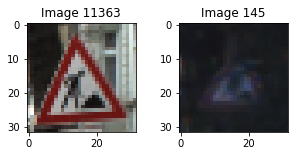

conv1/conv1:0 for Test Image 11363 - Correctly Predicted? True


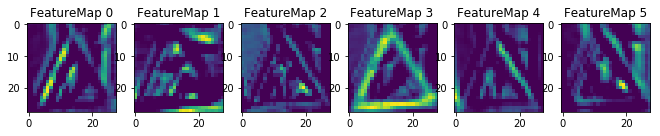

conv1/conv1:0 for Test Image 145 - Correctly Predicted? False


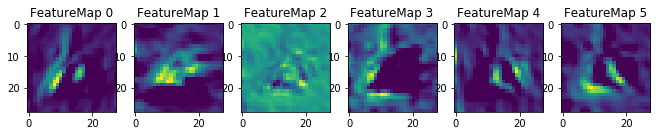

conv2/conv2:0 for Test Image 11363 - Correctly Predicted? True


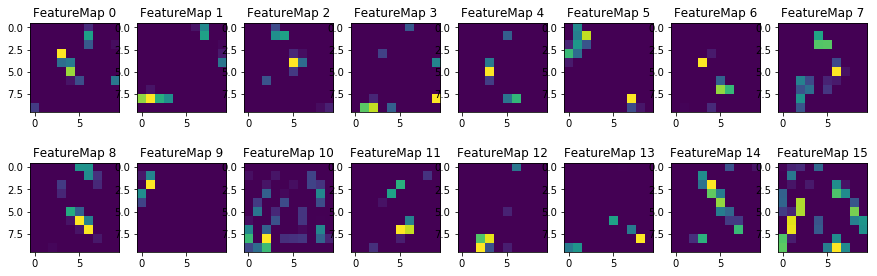

conv2/conv2:0 for Test Image 145 - Correctly Predicted? False


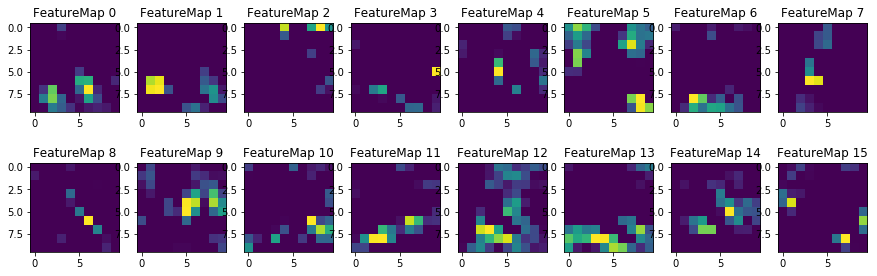

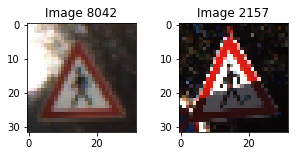

conv1/conv1:0 for Test Image 8042 - Correctly Predicted? True


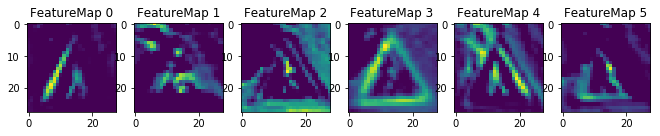

conv1/conv1:0 for Test Image 2157 - Correctly Predicted? False


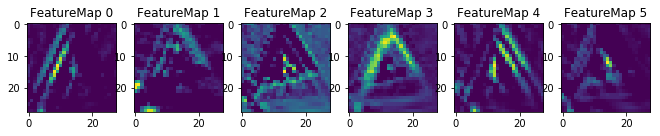

conv2/conv2:0 for Test Image 8042 - Correctly Predicted? True


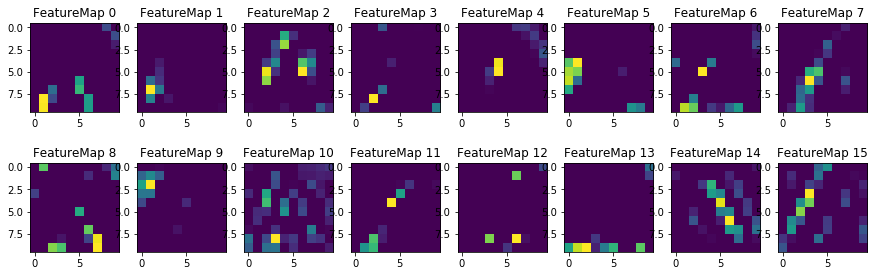

conv2/conv2:0 for Test Image 2157 - Correctly Predicted? False


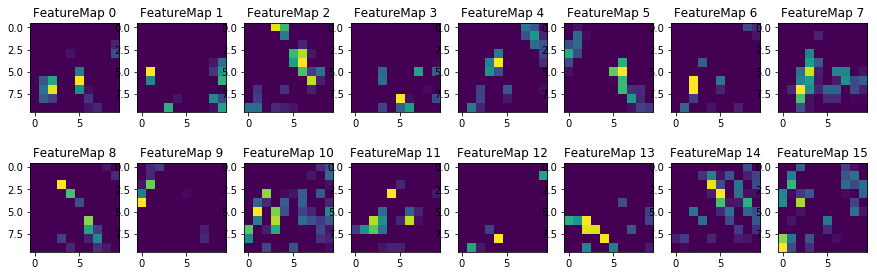

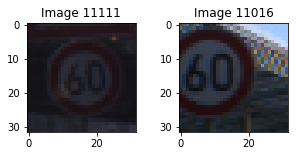

conv1/conv1:0 for Test Image 11111 - Correctly Predicted? True


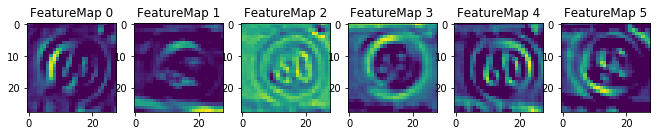

conv1/conv1:0 for Test Image 11016 - Correctly Predicted? False


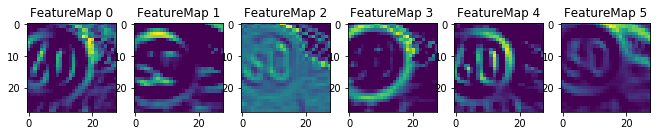

conv2/conv2:0 for Test Image 11111 - Correctly Predicted? True


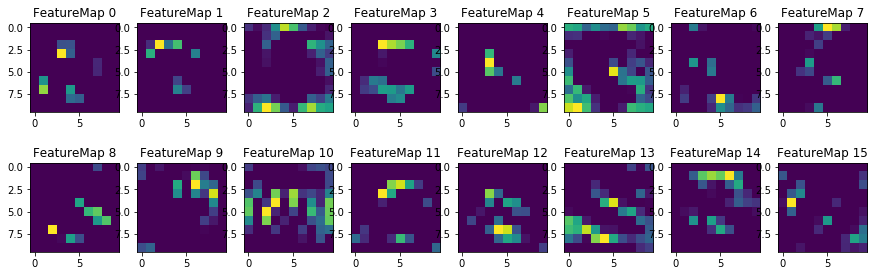

conv2/conv2:0 for Test Image 11016 - Correctly Predicted? False


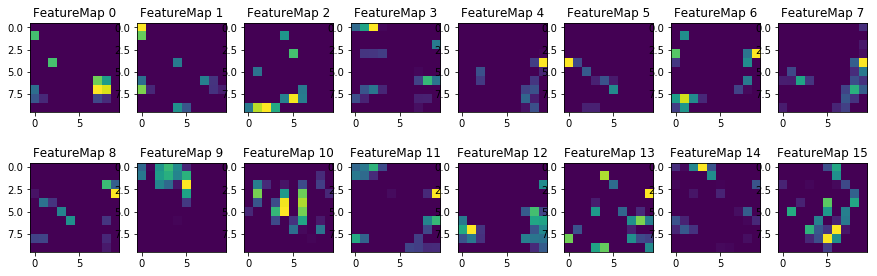

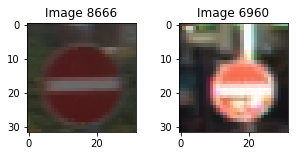

conv1/conv1:0 for Test Image 8666 - Correctly Predicted? True


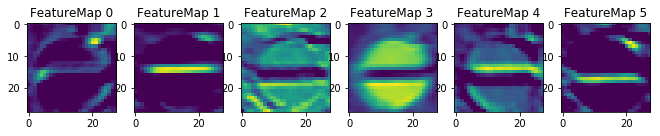

conv1/conv1:0 for Test Image 6960 - Correctly Predicted? False


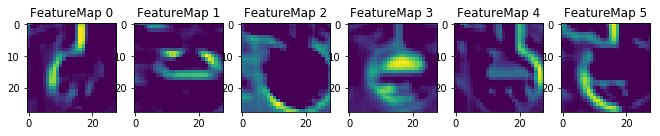

conv2/conv2:0 for Test Image 8666 - Correctly Predicted? True


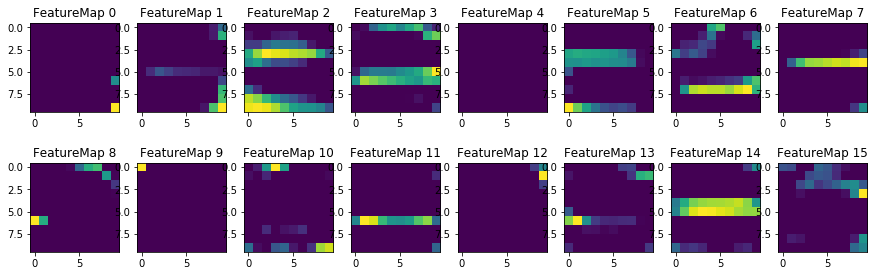

conv2/conv2:0 for Test Image 6960 - Correctly Predicted? False


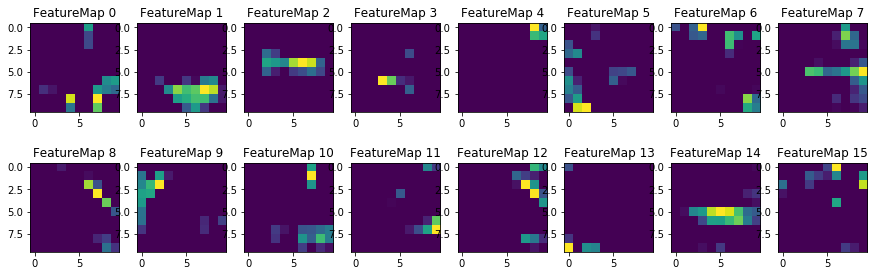

In [41]:
data = X_test_

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    
    print("Comparison on activations of correct/incorrect pairs:")
    for idx1, idx2 in image_pairs:
        img1, img2 = data[idx1], data[idx2]
        plt.figure(1, figsize=(5, 2))
        plt.subplot(121)
        plt.title("Image {}".format(idx1))
        plt.imshow(img1)
        plt.subplot(122)
        plt.title("Image {}".format(idx2))
        plt.imshow(img2)
        plt.show()
        
        img1 = (img1 - 128.) / 128.
        img1 = np.expand_dims(img1, axis=0)
        img2 = (img2 - 128.) / 128.
        img2 = np.expand_dims(img2, axis=0)
    
        print("conv1/conv1:0 for Test Image {}".format(idx1), end=' - ')
        print("Correctly Predicted? {}".format(correct_pred[idx1]))
        activation = tf.get_default_graph().get_tensor_by_name('conv1/conv1:0')    
        outputFeatureMap(img1, activation, plt_num=2)
        
        print("conv1/conv1:0 for Test Image {}".format(idx2), end=' - ')
        print("Correctly Predicted? {}".format(correct_pred[idx2]))   
        outputFeatureMap(img2, activation, plt_num=3)

        print("conv2/conv2:0 for Test Image {}".format(idx1), end=' - ')
        print("Correctly Predicted? {}".format(correct_pred[idx1]))
        activation = tf.get_default_graph().get_tensor_by_name('conv2/conv2:0')    
        outputFeatureMap(img1, activation, plt_num=4)
        
        print("conv2/conv2:0 for Test Image {}".format(idx2), end=' - ')
        print("Correctly Predicted? {}".format(correct_pred[idx2]))  
        outputFeatureMap(img2, activation, plt_num=5)

#### Let's compare two correct results with an incorrect one for the class 'No entry' 
Visualize only conv2 layer, since this layer conveys more important features

Comparison on conv2 activations of two correct and one incorrect images:


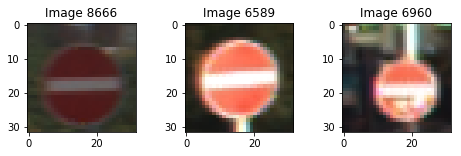

conv2/conv2:0 for Test Image 8666 - Correctly Predicted? True


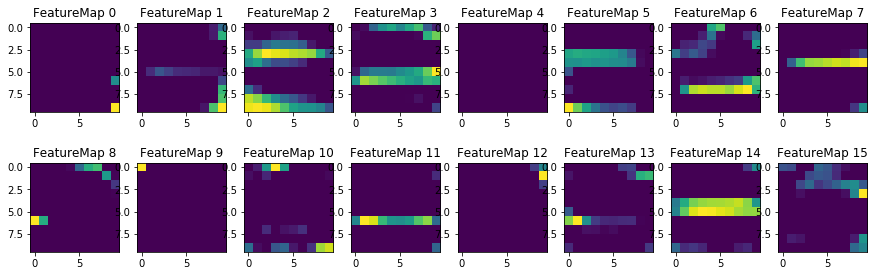

conv2/conv2:0 for Test Image 6960 - Correctly Predicted? True


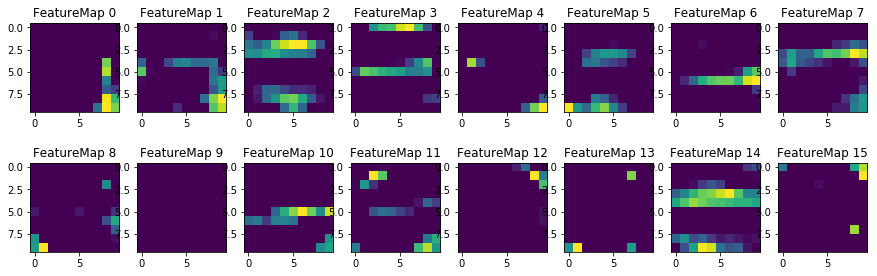

conv2/conv2:0 for Test Image 6960 - Correctly Predicted? False


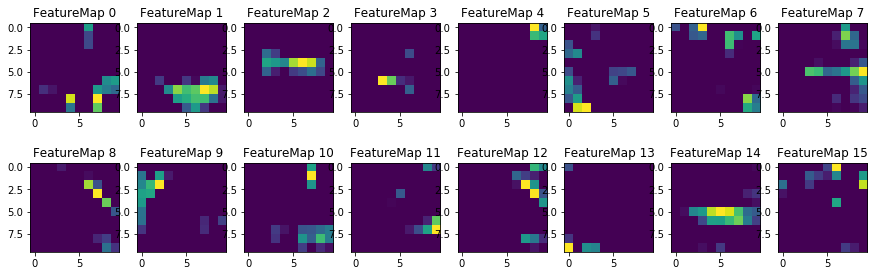

In [42]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    
    print("Comparison on conv2 activations of two correct and one incorrect images:")
    corr1, corr2, incorr = no_entry_pat 
    img1, img2, img3 = data[corr1], data[corr2], data[incorr]
    plt.figure(1, figsize=(8, 2))
    plt.subplot(131)
    plt.title("Image {}".format(corr1))
    plt.imshow(img1)
    plt.subplot(132)
    plt.title("Image {}".format(corr2))
    plt.imshow(img2)
    plt.subplot(133)
    plt.title("Image {}".format(incorr))
    plt.imshow(img3)
    plt.show()

    img1 = (img1 - 128.) / 128.
    img1 = np.expand_dims(img1, axis=0)
    img2 = (img2 - 128.) / 128.
    img2 = np.expand_dims(img2, axis=0)
    img3 = (img3 - 128.) / 128.
    img3 = np.expand_dims(img3, axis=0)

    print("conv2/conv2:0 for Test Image {}".format(idx1), end=' - ')
    print("Correctly Predicted? {}".format(correct_pred[corr1]))
    activation = tf.get_default_graph().get_tensor_by_name('conv2/conv2:0')    
    outputFeatureMap(img1, activation, plt_num=2)

    print("conv2/conv2:0 for Test Image {}".format(idx2), end=' - ')
    print("Correctly Predicted? {}".format(correct_pred[corr2]))  
    outputFeatureMap(img2, activation, plt_num=3)

    print("conv2/conv2:0 for Test Image {}".format(idx2), end=' - ')
    print("Correctly Predicted? {}".format(correct_pred[incorr])) 
    outputFeatureMap(img3, activation, plt_num=4)

We can see that the horizontal line patterns are shown in most feature maps in the first two activations (they are also correctly classified). However, this type of pattern is apparently less seen in the third activation; further more, FeatureMap8 seems to have a triangular pattern, which is likely a contribution to the wrong classification.

#### What are the activations look like for non- traffic sign images?

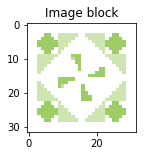

Activation for block 
conv1/conv1:0


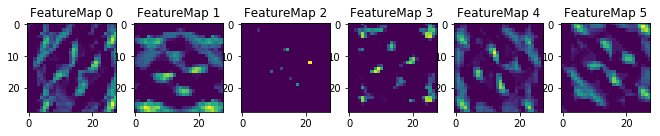

conv2/conv2:0


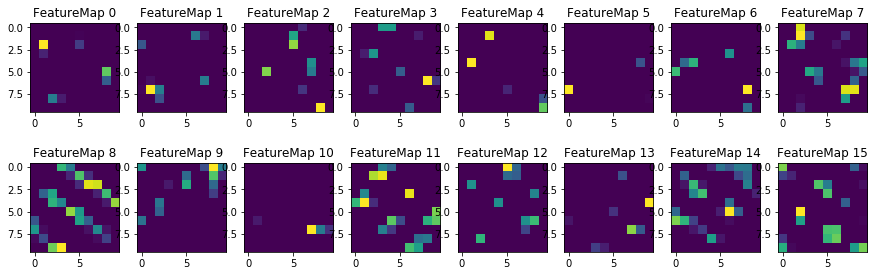

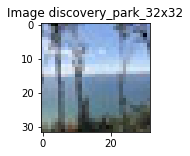

Activation for discovery_park_32x32 
conv1/conv1:0


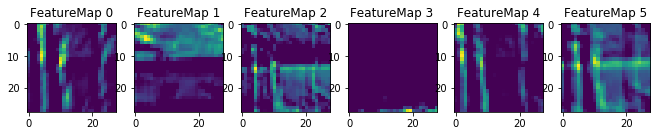

conv2/conv2:0


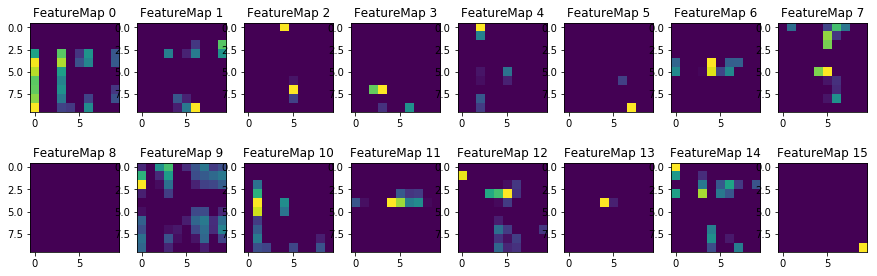

In [43]:
if platform.system() == 'Linux':
    other_image_dir = '/home/carnd/CarND-Traffic-Sign-Classifier-Project/not_signs_images/'
else:
    other_image_dir = '/Users/yiwenw/Documents/Udacity/SDCND/term1/CarND-Traffic-Sign-Classifier-Project/not_signs_images/'
    
other_images_, other_files = read_images_from_dir(other_image_dir)

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    
    for image, f in zip(other_images_, other_files):
        fname = f.split('.')[0]
        plt.figure(1, figsize=(5, 2))
        plt.title("Image {}".format(fname))
        plt.imshow(image)
        plt.show()
        
        image = (image - 128.) / 128.
        if (len(image.shape) == 3):
            image = np.expand_dims(image, axis=0)
    
        print("Activation for {} \nconv1/conv1:0".format(fname))
        activation = tf.get_default_graph().get_tensor_by_name('conv1/conv1:0')    
        outputFeatureMap(image, activation, plt_num=2)

        print("conv2/conv2:0".format(fname))
        activation = tf.get_default_graph().get_tensor_by_name('conv2/conv2:0')
        outputFeatureMap(image, activation, plt_num=3)

The activation for image 'blocks' seems quite random, except FeatureMap8 which might indicate the image's two 135 degree lines. For the 'discovery_park_32x32' image, we can see that the vertical line pattern is captured in several feature maps. That said, even though there's no obvious long vertical lines in training data, the network can still extract that information. 

#### Some amazing work of the NN
There are images that I find hard to recognize for machines (even for human).    
BUT the network classifies them correctly. 
Amazing!!  
Below are some of them.

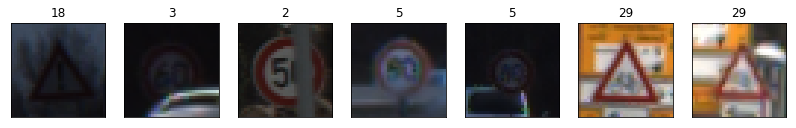

In [44]:
amaze_images = X_test_[amaze_correct]
amaze_labels = y_test[amaze_correct]
display_all_images(amaze_images, amaze_labels)